In [ ]:
import matplotlib.pyplot as plt
import os
import torch
from typing import List
import pandas as pd
import gluonts
import numpy as np
import nnts
import nnts.data
import nnts.experiments
import nnts.torch.preprocessing
import nnts.torch.models
import trainers
import nnts.metrics
import nnts.torch.datasets
import nnts.loggers
import nnts.pandas
import nnts
import nnts.experiments.plotting
import projects.deepar.runner as runner
from projects.deepar.runner import LagScenario

torch.set_printoptions(precision=8, sci_mode=False)
%load_ext autoreload
%autoreload 2

In [ ]:
data_path = "data"
model_name = "distr-deepar"
base_model_name = "base-lstm"
dataset_name = "tourism"
results_path = "ablation-results"
metadata_path = os.path.join(data_path, f"{base_model_name}-monash.json")
metadata = nnts.metadata.load(dataset_name, path=metadata_path)
datafile_path = os.path.join(data_path, metadata.filename)
PATH = os.path.join(results_path, model_name, metadata.dataset)

df_orig, *_ = nnts.pandas.read_tsf(datafile_path)
params = nnts.hyperparams.Hyperparams()
params.optimizer = torch.optim.Adam

nnts.loggers.makedirs_if_not_exists(PATH)

In [ ]:
#Gluonts defaults
params.batch_size = 32
params.batches_per_epoch = 50

In [ ]:
def create_time_features(df_orig: pd.DataFrame):
    df_orig["day_of_week"] = df_orig["ds"].dt.day_of_week
    df_orig["hour"] = df_orig["ds"].dt.hour
    df_orig["week"] = df_orig["ds"].dt.isocalendar().week
    df_orig["week"] = df_orig["week"].astype(np.float32)

    df_orig["month"] = df_orig["ds"].dt.month

    df_orig["unix_timestamp"] = np.log10(2.0 + df_orig.groupby("unique_id").cumcount())

    return df_orig

In [ ]:
df_orig = create_time_features(df_orig)


def create_dummy_unique_ids(df_orig: pd.DataFrame):
    df_orig["unique_id_0"] = 0.0
    df_orig["unique_id_1"] = 0.0597
    return df_orig


df_orig = create_dummy_unique_ids(df_orig)

# Normalize data
max_min_scaler = nnts.torch.preprocessing.MaxMinScaler()
max_min_scaler.fit(df_orig, ["month"])
df_orig = max_min_scaler.transform(df_orig, ["month"])


In [ ]:
# GlounTS uses the following code to generate the month covariate used in the tourism dataset
# the month value is extracted from the date column and then scaled to a value between -0.5 and 0.5
# here we do this is on the whole dataset in one go
max_min_scaler = nnts.torch.preprocessing.MaxMinScaler()
max_min_scaler.fit(df_orig, ["unix_timestamp"])
df_orig = max_min_scaler.transform(df_orig, ["unix_timestamp"])

In [ ]:
ax = df_orig[df_orig['unique_id'] == 'T1'].set_index('ds').tail(36)['month'].plot(figsize=(20, 5))
fig = ax.get_figure()

In [ ]:
from dataclasses import dataclass, field
lag_seq = gluonts.time_feature.lag.get_lags_for_frequency(metadata.freq)
lag_seq = [lag - 1 for lag in lag_seq if lag > 1]

In [ ]:

scaled_covariates = ["month", "unix_timestamp", nnts.torch.models.deepar.FEAT_SCALE]

scaled_covariate_selection_matrix = [
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1],
]

In [ ]:
scenario_list: List[nnts.experiments.Scenario] = []

for seed in [42, 43, 44, 45, 46]:
    for row in scaled_covariate_selection_matrix:
        selected_combination = [
            covariate
            for covariate, select in zip(scaled_covariates, row)
            if select == 1
        ]
        scenario_list.append(
            LagScenario(
                metadata.prediction_length,
                conts=[cov for cov in selected_combination if cov != nnts.torch.models.deepar.FEAT_SCALE],
                scaled_covariates=selected_combination,
                lag_seq=lag_seq,
                seed=seed,
                dataset=metadata.dataset,
            )
        )

In [ ]:
# BASELINE
conts = [
    "month",
    "unix_timestamp",
    "unique_id_0",
]
scenario_list = []
for seed in [42, 43, 44, 45, 46]:
    scenario = LagScenario(
        metadata.prediction_length,
        conts=conts,
        scaled_covariates=conts+ [
                nnts.torch.models.deepar.FEAT_SCALE,
            ],
        lag_seq=lag_seq,
        seed=seed,
        dataset=metadata.dataset,
    )
    scenario_list.append(scenario)

In [ ]:
# DeepAR uses Teacher Forcing but we can use Free Running
params.training_method = nnts.hyperparams.Hyperparams.TrainingMethod.TEACHER_FORCING

In [ ]:
import torch.nn as nn
import torch.distributions as td
import torch.nn.functional as F

In [ ]:

class StudentTHead(nn.Module):
    """
    This model outputs a studentT distribution.
    """
    PARAMS = 2
    def __init__(self, hidden_size: int, output_size: int):
        super(StudentTHead, self).__init__()

        self.main = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size*StudentTHead.PARAMS),
        )

    def forward(self, x: torch.tensor, target_scale: torch.tensor):
        y_hat = self.main(x)
        df = F.softplus(y_hat[..., 0:1])
        loc = y_hat[..., 1:2]
        scale = target_scale if target_scale is not None else 1
        return td.StudentT(df, loc, scale)
    

def distr_nll(distr: td.Distribution, target: torch.Tensor) -> torch.Tensor:
    return -distr.log_prob(target).mean()

In [ ]:
for scenario in scenario_list:
    nnts.torch.datasets.seed_everything(scenario.seed)
    df = df_orig.copy()
    context_length = metadata.context_length + max(scenario.lag_seq)
    split_data = nnts.pandas.split_test_train_last_horizon(
        df, context_length, metadata.prediction_length
    )
    trn_dl, test_dl = nnts.data.create_trn_test_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.datasets.TorchTimeseriesLagsDataLoaderFactory(),
    )
    logger = nnts.loggers.LocalFileRun(
        project=f"{model_name}-{metadata.dataset}",
        name=scenario.name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
        path=PATH,
    )
    net = nnts.torch.models.DistrDeepAR(
        StudentTHead,
        params,
        nnts.torch.preprocessing.masked_mean_abs_scaling,
        1,
        lag_seq=lag_seq,
        scaled_features=scenario.scaled_covariates,
    )
    trner = trainers.TorchEpochTrainer(
        nnts.trainers.TrainerState(), 
        net, 
        params, 
        metadata, 
        os.path.join(PATH, f"{scenario.name}.pt"),
        loss_fn=distr_nll
    )
    logger.configure(trner.events)

    evaluator = trner.train(trn_dl)
    y_hat, y = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, nnts.metrics.calculate_seasonal_error(trn_dl, metadata)
    )
    logger.log(test_metrics)
    print(test_metrics)
    logger.finish()

In [ ]:
csv_aggregator = nnts.pandas.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

In [ ]:
results = pd.read_csv(f"{PATH}/results.csv")
results

In [ ]:
results[['smape', 'mase']].mean()

In [ ]:
df_list = runner.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = nnts.experiments.plotting.plot(df_list, scenario.prediction_length)

In [ ]:
from gluonts.dataset.repository import dataset_names, get_dataset

dataset = get_dataset("tourism_monthly")

In [ ]:
import gluonts.evaluation.metrics
import torch

In [ ]:
se_list = []
for batch in dataset.train:
    past_data = batch["target"]
    se = gluonts.evaluation.metrics.calculate_seasonal_error(past_data, "1M", 12)
    se_list.append(se)
torch.tensor(se_list).mean()

In [ ]:
import torch
import gluonadapt

In [ ]:
input = torch.load(
    "/Users/garethdavies/Development/workspaces/gluonts/examples/input.pt"
)

In [ ]:
dl = gluonadapt.get_test_dataloader()

In [ ]:
for scenario in scenario_list[:1]:
    nnts.torch.datasets.seed_everything(scenario.seed)
    df = df_orig.copy()
    context_length = metadata.context_length + max(scenario.lag_seq)
    split_data = nnts.pandas.split_test_train_last_horizon(
        df, context_length, metadata.prediction_length
    )
    trn_dl, test_dl = nnts.data.create_trn_test_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.datasets.TorchTimeseriesLagsDataLoaderFactory(),
    )

In [ ]:
batch = next(iter(test_dl))

In [ ]:
torch.allclose(batch["X"][:, :51, 2], dl[0]["X"][:, :51, 2])

In [ ]:
plt.plot(batch['X'][10, :51, 2])

In [ ]:
plt.plot(dl[0]['X'][10, :51, 2])

In [ ]:
dl[0]['X'][0, :, 0]

In [ ]:
dl[0]['X'].shape

In [ ]:
state_dict = torch.load(
    "/Users/garethdavies/Development/workspaces/nnts/projects/deepar/gluonts.pt"
)
rnn = {k: v for k, v in state_dict.items() if k.startswith("rnn")}
net.decoder.load_state_dict(rnn)
net.embbeder.load_state_dict({"weight": state_dict["embedder._embedders.0.weight"]})

In [ ]:
{k: v for k, v in state_dict.items() if not k.startswith("rnn")}

In [49]:
import nnts.pandas

In [63]:
PATH = "baseline-results/deepar-point/electricity/"
csv_aggregator = nnts.pandas.CSVFileAggregator(PATH, "results")
results = csv_aggregator()
univariate_results = results.loc[:, ["smape", "mase"]]
print(
    univariate_results.mean(), univariate_results.std(), univariate_results.count()
)

smape    0.206618
mase     1.736845
dtype: float64 smape    0.013707
mase     0.184862
dtype: float64 smape    5
mase     5
dtype: int64


In [68]:
import pandas as pd
pd.options.display.float_format = "{:.3f}".format
df = pd.read_csv("../better_deepar/ablation-results/better-deepar-studentt/m4_hourly/results.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../better_deepar/ablation-results/better-deepar-studentt/m4_hourly/results.csv'

In [69]:
df[[
    "mse",
    "abs_error",
    "abs_target_sum",
    "abs_target_mean",
    "mase",
    "mape",
    "smape",
    "nd",
    "mae",
    "rmse",
    "seasonal_error",
]].mean()

KeyError: "None of [Index(['mse', 'abs_error', 'abs_target_sum', 'abs_target_mean', 'mase', 'mape',\n       'smape', 'nd', 'mae', 'rmse', 'seasonal_error'],\n      dtype='object')] are in the [columns]"

In [3]:
import torch.utils.data

sample_dataset = torch.utils.data.TensorDataset(
    torch.randn(10, 5), torch.randint(0, 2, (10,))
)
sample_dataset


In [5]:
len(sample_dataset)

10

In [4]:
import nnts.hyperparams
str(nnts.hyperparams.Scheduler.REDUCE_LR_ON_PLATEAU)

'Scheduler.REDUCE_LR_ON_PLATEAU'

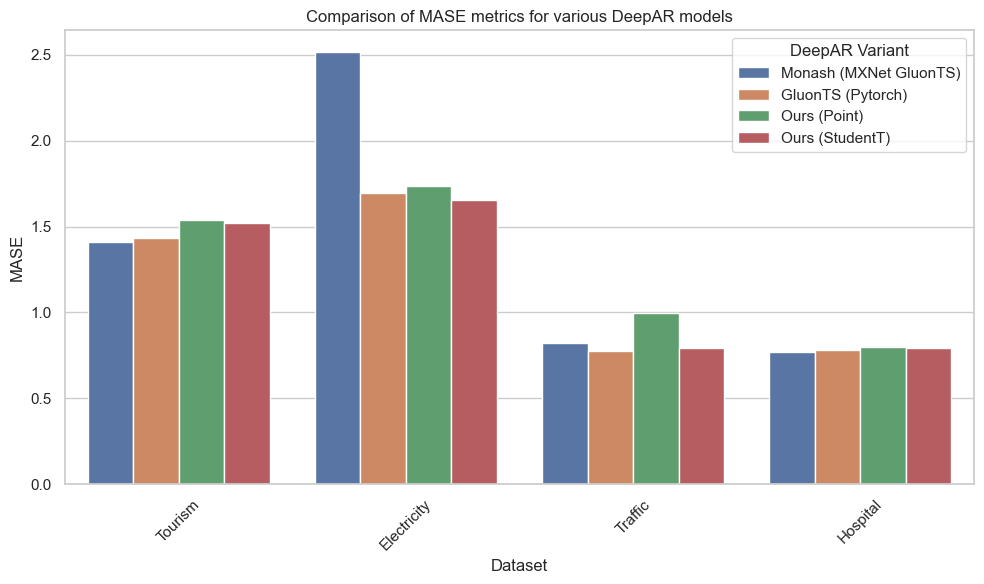

In [67]:
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the Markdown data to a dictionary
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
# Convert the Markdown data to a dictionary
data = {
    "Dataset": ["Tourism", "Electricity", "Traffic", "Hospital"],
    "Monash (MXNet GluonTS)": [1.409, 2.516, 0.825, 0.769],
    "GluonTS (Pytorch)": [1.432, 1.697, 0.774, 0.784],
    "Ours (Point)": [1.538, 1.737, 0.999, 0.799],
    "Ours (StudentT)": [1.523, 1.656, 0.792, 0.794],
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for Seaborn
df_melted = df.melt(id_vars="Dataset", var_name="Method", value_name="Value")

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Dataset", y="Value", hue="Method", data=df_melted)

# Add labels and title
plt.xlabel("Dataset")
plt.ylabel("MASE")
plt.title("Comparison of MASE metrics for various DeepAR models")
plt.legend(title="DeepAR Variant")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df_orig, *_ = nnts.pandas.read_tsf(os.path.join(data_path, metadata.filename))